## training한 데이터를 평가해보자!

### NDCG - Normalized Discounted Cumulative Gain

- 추천시스템에서 랭킹 추천 분야에 많이 쓰이는 평가지표
- NDCG는 0~1사이의 값을 갖게되는데 1과 가까울수록 우수한 추천시스템 (아래 참고) 
<br>
<br>
- Cumulative Gain(CG) : 관련성 점수(사용자가 추천된 각 아이템을 얼마나 선호하는지를 나타내는 점수)를 합한 값
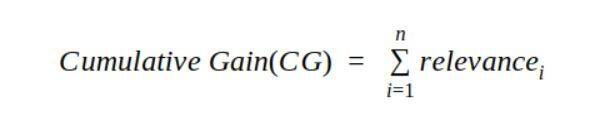
 *(!) 우리의 관련성 점수(Relavance Score)는 Binary : 0(not in playlist), 1(in playlist)*  
<br>
<br>
- DCG(DiscountCG) : CG에 Ranking별 가중치를 적용한 것
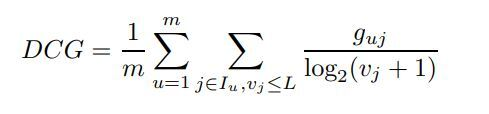
    - g_uj = Relavance Score(추천곡이 실제 플리에 들어있으면 1, 아니면 0)
    - v_j는 추천한 노래의 랭킹(Ranking) (몇 번째로 추천해줬는지, 추천곡의 index값)  
    - L: 추천곡 리스트의 길이, m: 플레이리스트 수(데이터 수) 
<br>
<br>
- NDCG(NormalizedDCG)
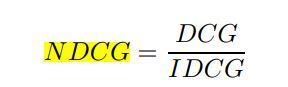
    - 즉 NDCG가 1이라는 것은 IDCG = DCG인 경우이므로, 우리가 정답을 모두 맞췄을 경우!
 
 *(!) IDCG(Ideal Discounted Cumulative gain): L개의 결과를 rel이 큰 순서대로 정렬한 rel+opt에 대해서 DCG해준 값(우리의 경우엔 정답리스트의 DCG)*  
 
 <br>  
 즉, 모든 테스트 셋 유저들에 대한 추천의 평균 NDCG를 구하여 모델의 성능을 평가!!

In [8]:
import numpy as np

import import_ipynb
from util import write_json, load_json

class CustomEvaluator:
    def _idcg(self, l): # 우리의 Relavance Score가 Binary여서 미리 계산 가능!
        return sum((1.0 / np.log(i + 2) for i in range(l))) # 분모가 0이 되는 것을 막기 위해 np.log(i + 1) 대신, np.log(i + 2) 사용

    def __init__(self): # 생성자
        self._idcgs = [self._idcg(i) for i in range(6)] # _idcgs = [_idcg(0), _idcg(1), ... , _idcg(5)] (ground truth값이 가변한다고 가정, 우리는 일단 고정)

    def _ndcg(self, gt, rec): # gt: ground truth, rec: 추천곡 리스트(예측값)
        dcg = 0.0 # 다 틀리면 ndcg가 0!
        for i, r in enumerate(rec): # 추천곡 리스트에서 추천곡을 하나씩 꺼냄! (i: 해당 추천곡의 index(ranking), r: 추천곡)
            if r in gt: # ground truth안에 추천곡이 있으면
                dcg += 1.0 / np.log(i + 2) # 추천 순서에 따라 가중치를 준 dcg

        return dcg / self._idcgs[len(gt)] # ground truth길이에 맞는 idcgs를 select! (우리는 고정시킬 예정!)

    def _eval(self, gt_fname, rec_fname):
        gt_playlists = load_json(gt_fname) # ground truth(정답 리스트)
        gt_dict = {g["id"]: g for g in gt_playlists}
        rec_playlists = load_json(rec_fname) # 예측한 추천곡 리스트!
        
        music_ndcg = 0.0 

        for rec in rec_playlists: # 우리의 추천곡을 하나씩 꺼내와서
            gt = gt_dict[rec["id"]] # gt: 추천곡의 id와 같은 id를 갖는 ground trueth
            music_ndcg += self._ndcg(gt["songs"], rec["songs"][:3]) # rec["songs"]에서 0번부터 3개만!

        score = music_ndcg / len(rec_playlists) # score는 모든 테스트 셋 유저들에 대한 추천의 평균 NDCG

        return music_ndcg, score

    def evaluate(self, gt_fname, rec_fname): # evaluate하는 함수!
        try:
            music_ndcg, score = self._eval(gt_fname, rec_fname) # _eval()함수 호출
            print(f"Music nDCG: {music_ndcg:.6}")
            print(f"Score: {score:.6}")
        except Exception as e:
            print(e)


# if __name__ == "__main__":
#     fire.Fire(ArenaEvaluator)

### 평가를 하고 싶다면 아래 주석 참고!!

In [6]:
# evaluator = CustomEvaluator()
# evaluator.evaluate("실제(정답) 플레이리스트 파일 경로", "예측한 추천곡 플레이리스트 파일 경로")